In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import h5py

from akita_utils.utils import ut_dense
from akita_utils.stats_utils import get_map_matrix, plot_map
from akita_utils.h5_utils import infer_num_jobs

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def find_lower_boundary(request_exp_id, chunks_bounds):
    """
    Find the index of the biggest bound smaller than the requested experiment ID.

    This function takes a requested experiment ID and a list of chunk boundaries. It iterates
    through the boundaries and finds the index of the biggest boundary that is smaller than the
    requested experiment ID. This index indicates the corresponding chunk where the requested
    experiment is located.

    Parameters:
    - request_exp_id (int): Requested experiment ID to locate within the chunks.
    - chunks_bounds (list): List of chunk boundaries used for splitting the data.

    Returns:
    int: Index of the biggest boundary smaller than the requested experiment ID.
    """
    biggest_chunks_bound_index = 0
    for chunks_bound_index in range(len(chunks_bounds)):
        chunks_bound = chunks_bounds[chunks_bound_index]
        if chunks_bound < request_exp_id:
            biggest_chunks_bound_index = chunks_bound_index
        if chunks_bound > request_exp_id:
            return biggest_chunks_bound_index

def which_job(request_seq_id, request_bg_id, split_df, nr_sites, num_chunks):
    """
    Determine the job index for a requested experiment based on sequence and background IDs.

    This function calculates the experiment ID based on the provided sequence ID, background ID,
    and the total number of sites. It then splits the experiment data into chunks and determines
    the index of the chunk where the requested experiment is located.

    Parameters:
    - request_seq_id (int): Requested sequence ID.
    - request_bg_id (int): Requested background ID.
    - split_df (pd.DataFrame): DataFrame containing split experiment data.
    - nr_sites (int): Total number of sites.
    - num_chunks (int): Number of chunks used for splitting the data.

    Returns:
    int: Index of the chunk where the requested experiment is located.
    """
    request_exp_id = request_bg_id * nr_sites + request_seq_id
    assert split_df.iloc[request_exp_id]["seq_id"] == request_seq_id

    # finding df boundaries
    df_len = len(split_df)
    chunks_bounds = np.linspace(0, df_len, num_chunks + 1, dtype="int")
    
    return find_lower_boundary(request_exp_id, chunks_bounds)

In [3]:
# df with scores averaged over targets, and backgrounds
scores_tsv = "./../ctcf_tsv/filtered_base_mouse_ctcf_scored_and_averaged.tsv"
scores_df = pd.read_table(scores_tsv, sep="\t")

In [4]:
# df with all experiments
experiments_tsv = "./../ctcf_tsv/filtered_base_mouse_ctcf_scored.tsv"
experiments_df = pd.read_table(experiments_tsv, sep="\t")

In [5]:
# parameters
nr_sites = len(scores_df)
model_index = 1
head_index = 1

# background and target ids
request_bg_id = 3
request_tg_ids = [3]

num_chunks = infer_num_jobs("/scratch2/smaruj/all_dots_vs_boundaries/maps_boundaries_all_motifs_m1")

# Restricting score

In [85]:
from random import sample

In [47]:
# Averaging over models

model_indices = [1, 2]
col_names = ["boSCD", "dotSCD", "dot-score", "cross-score", "x-score"]

for score in col_names:
    ave_column_name = f"{score}_avg"
    columns_to_ave = [f"{score}_m{model_index}" for model_index in model_indices]
    scores_df[ave_column_name] = scores_df[columns_to_ave].mean(axis=1)

In [86]:
nr_maps = 15
# column_name = "boSCD_avg"
column_name = "cross-score_avg"
upperbound = 0.2
lowerbound = 0.0

In [87]:
restricted_seq_ids = list(scores_df[(scores_df[column_name] <= upperbound) & (scores_df[column_name] > lowerbound)].seq_id)

In [88]:
len(restricted_seq_ids)

6640

In [89]:
if len(restricted_seq_ids) <= nr_maps:
    sample = restricted_seq_ids
else:
    sample = sample(restricted_seq_ids, nr_maps)
sample.sort()

In [90]:
sample_exp_id = [nr_sites * request_bg_id + seq_id for seq_id in sample]

In [91]:
# figuring out in which jobs are requested samples
job_list = []

for seq_id in sample:
    index = which_job(seq_id, request_bg_id, experiments_df, nr_sites, num_chunks)
    if index not in job_list:
        job_list.append(index)

In [92]:
job_list

[6, 7]

# Boundary maps

# for job_index in job_list:
    
    job_h5_file = f"/scratch2/smaruj/all_dots_vs_boundaries/maps_boundaries_all_motifs_m{model_index}/job{job_index}/MAPS_OUT.h5"
    job_h5_open = h5py.File(job_h5_file, "r")
    
    exp_ids = job_h5_open["exp_id"]
    min_exp_id, max_exp_id = exp_ids[0], exp_ids[-1]

    for exp_id in exp_ids:
        if exp_id in sample_exp_id:
            
            print("EXP_ID: ", exp_id)
            preds_matrix = job_h5_open[f"map_h{head_index}_m{model_index}"][exp_id-min_exp_id, :, :]
            map_matrix = ut_dense(preds_matrix)

            for request_tg_id in request_tg_ids:
                print("\t-target: ", request_tg_id)
                plot_map(map_matrix[:, :, request_tg_id])
    
    job_h5_open.close()


# Dot maps

EXP_ID:  22684
	-target:  3


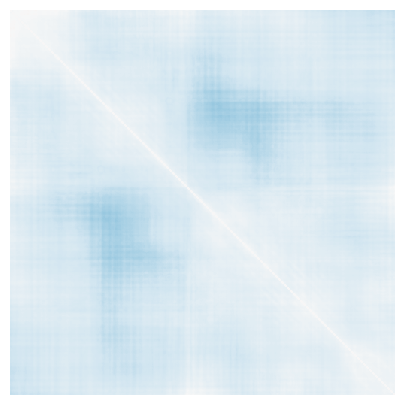

EXP_ID:  22698
	-target:  3


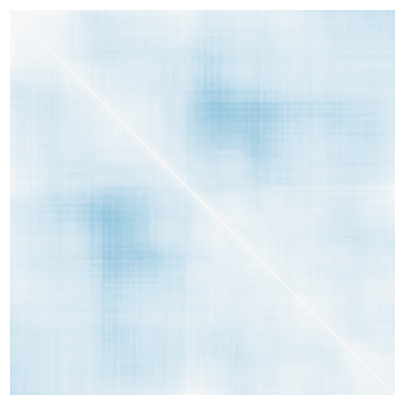

EXP_ID:  22938
	-target:  3


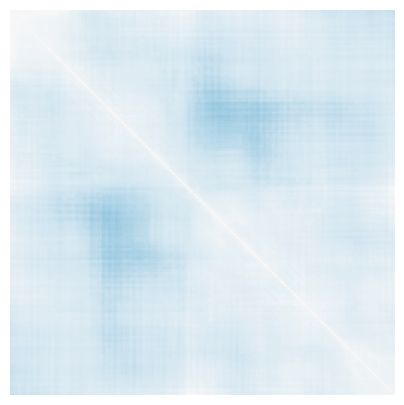

EXP_ID:  24026
	-target:  3


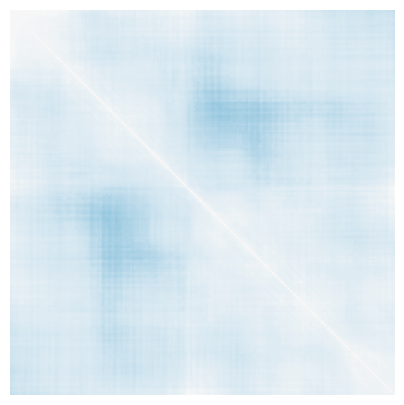

EXP_ID:  24227
	-target:  3


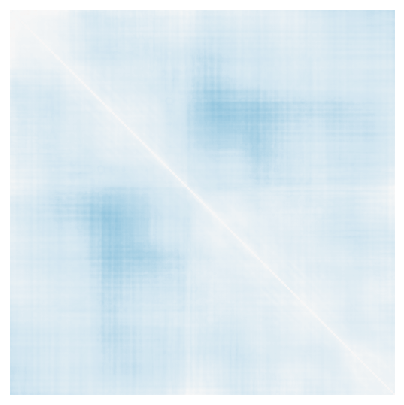

EXP_ID:  25143
	-target:  3


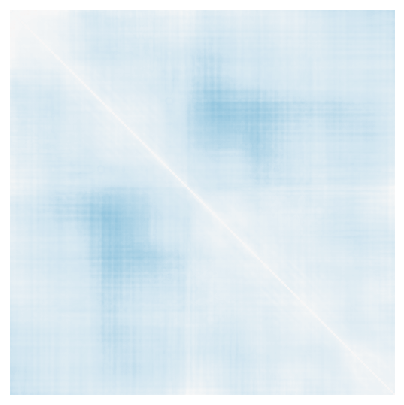

EXP_ID:  25461
	-target:  3


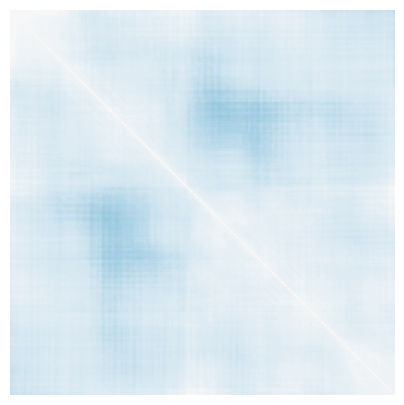

EXP_ID:  25665
	-target:  3


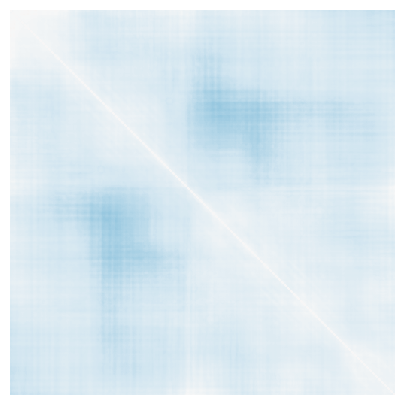

EXP_ID:  26386
	-target:  3


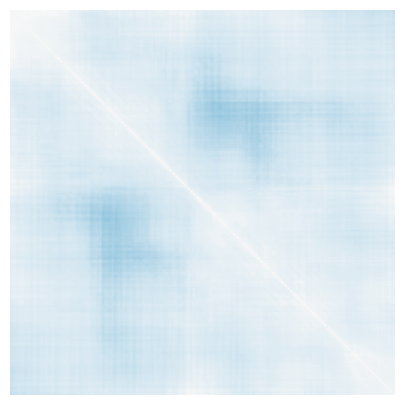

EXP_ID:  27027
	-target:  3


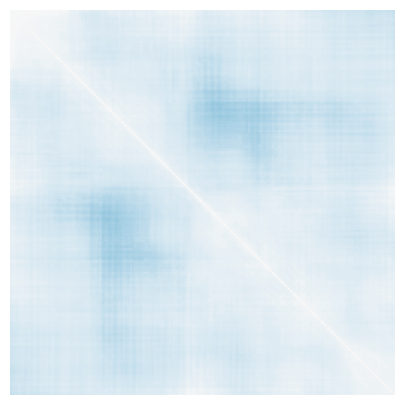

EXP_ID:  28232
	-target:  3


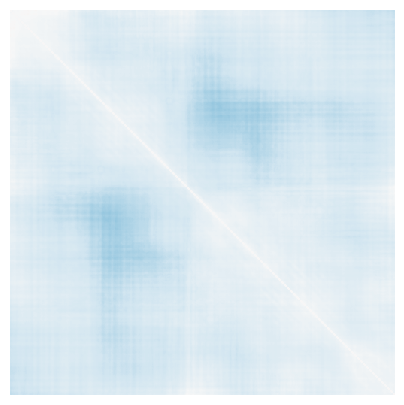

EXP_ID:  28514
	-target:  3


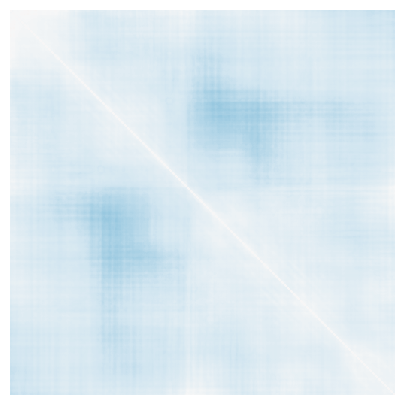

EXP_ID:  28947
	-target:  3


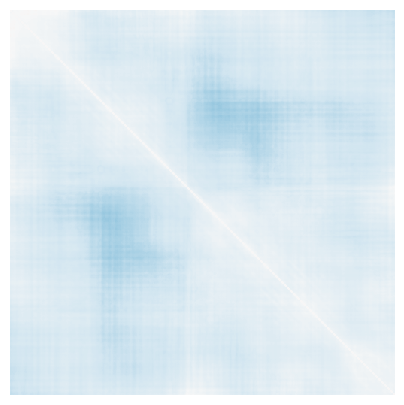

EXP_ID:  28990
	-target:  3


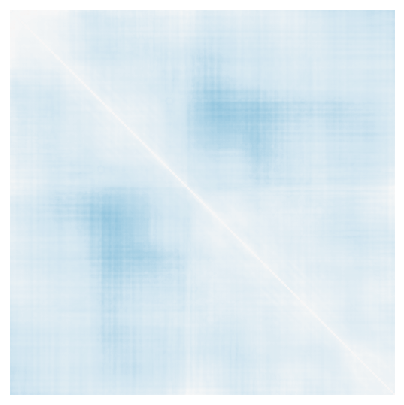

EXP_ID:  30011
	-target:  3


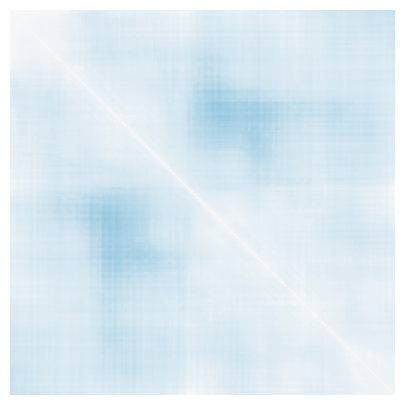

In [93]:
for job_index in job_list:
    
    job_h5_file = f"/scratch2/smaruj/all_dots_vs_boundaries/maps_dots_all_motifs_m{model_index}/job{job_index}/MAPS_OUT.h5"
    job_h5_open = h5py.File(job_h5_file, "r")
    
    exp_ids = job_h5_open["exp_id"]
    min_exp_id, max_exp_id = exp_ids[0], exp_ids[-1]

    for exp_id in exp_ids:
        if exp_id in sample_exp_id:
            
            print("EXP_ID: ", exp_id)
            preds_matrix = job_h5_open[f"map_h{head_index}_m{model_index}"][exp_id-min_exp_id, :, :]
            map_matrix = ut_dense(preds_matrix)

            for request_tg_id in request_tg_ids:
                print("\t-target: ", request_tg_id)
                plot_map(map_matrix[:, :, request_tg_id])
    
    job_h5_open.close()